# 3D segmentation prediction
In this tutorial we will see how to predict model using simple 3D-UNet segmentation model

In [1]:
# Load 3D segmentation model object
#%% ####### load model object for 3d prediction
import torch
import torch.nn as nn
def conv_3d_block(cin,cout):
    conv_block=nn.Sequential(nn.Conv3d(cin,cout,3,1,1),
                             nn.ReLU(inplace=True),
                             nn.BatchNorm3d(cout),)
    return conv_block

class decode(nn.Module):
    def __init__(self,cin,cout):
        super(decode,self).__init__()
        self.decode=nn.ConvTranspose3d(cin,cout,2,2)
        self.conv_block=conv_3d_block(cin,cout)

    def forward(self,x1,x2):
        x1=self.decode(x1)
        #print(x1.shape)
        #decod=self.conv_block(concat)
        concat=torch.concat([x1,x2],dim=1)
        decod=self.conv_block(concat)
        return decod


class my_3D_UNet(nn.Module):
    def __init__(self):
        super(my_3D_UNet,self).__init__()
        ######### encoder block #######
        self.encod1=conv_3d_block(1,16) ### 16x64x128x128
        self.maxpool=nn.MaxPool3d(2)
        self.encod2=conv_3d_block(16,32)  ### 32x32x64x64
        self.encod3=conv_3d_block(32,64) ### 64x16x32x32
        self.botom=nn.Conv3d(64,128,3,1,1) ##### 128x8x16x16
        #### decoder block
        self.decod1=decode(128,64)
        self.decod2=decode(64,32)
        self.decod3=decode(32,16)
        self.final=nn.Conv3d(16,4,1)

    def forward(self,x):
        encod1=self.encod1(x)
        maxpool1=self.maxpool(encod1)
        #print(f'ecode1: {encod1.shape}')
        encod2=self.encod2(maxpool1)
        maxpool2=self.maxpool(encod2)
        #print(f'ecode2: {encod2.shape}')
        encod3=self.encod3(maxpool2)
        maxpool3=self.maxpool(encod3)
        #print(f'ecode3: {encod3.shape}')
        bottom=self.botom(maxpool3)
        #print(bottom.shape)
        #print(f'bottom: {bottom.shape}')
        ########### decode1 ###########
        decod1=self.decod1(bottom,encod3)
        decod2=self.decod2(decod1,encod2)
        decod3=self.decod3(decod2,encod1)
        out=self.final(decod3)
        return out
model=my_3D_UNet()

In [2]:
##################### load trained model ##################
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
path='C:/Users/aq22/Desktop/kcl2022/Pytorch_basic_tutorials/pytorch_segmentation_models/base_3D_UNet.pth'
model.load_state_dict(torch.load(path,torch.device('cpu')))
#%% prediction function for 3D-UNet segmentation
import numpy as np
import SimpleITK as sitk
from skimage.measure import regionprops
from glob import glob
import os

C:\Users\aq22\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
#model

In [5]:
############# croped and resize dataset files
def ResampleXYZAxis(imImage, space=(1., 1., 1.), interp=sitk.sitkLinear):
    identity1 = sitk.Transform(3, sitk.sitkIdentity)
    sp1 = imImage.GetSpacing()
    sz1 = imImage.GetSize()

    sz2 = (int(round(sz1[0]*sp1[0]*1.0/space[0])), int(round(sz1[1]*sp1[1]*1.0/space[1])), int(round(sz1[2]*sp1[2]*1.0/space[2])))

    imRefImage = sitk.Image(sz2, imImage.GetPixelIDValue())
    imRefImage.SetSpacing(space)
    imRefImage.SetOrigin(imImage.GetOrigin())
    imRefImage.SetDirection(imImage.GetDirection())

    imOutImage = sitk.Resample(imImage, imRefImage, identity1, interp)

    return imOutImage

def ResampleLabelToRef(imLabel, imRef, interp=sitk.sitkNearestNeighbor):
    identity1 = sitk.Transform(3, sitk.sitkIdentity)

    imRefImage = sitk.Image(imRef.GetSize(), imLabel.GetPixelIDValue())
    imRefImage.SetSpacing(imRef.GetSpacing())
    imRefImage.SetOrigin(imRef.GetOrigin())
    imRefImage.SetDirection(imRef.GetDirection())
        
    ResampledLabel = sitk.Resample(imLabel, imRefImage, identity1, interp)
    
    return ResampledLabel



def ITKReDirection(itkimg, target_direction=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)):
    # target direction should be orthognal, i.e. (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

    # permute axis
    tmp_target_direction = np.abs(np.round(np.array(target_direction))).reshape(3,3).T
    current_direction = np.abs(np.round(itkimg.GetDirection())).reshape(3,3).T
    
    permute_order = []
    if not np.array_equal(tmp_target_direction, current_direction):
        for i in range(3):
            for j in range(3):
                if np.array_equal(tmp_target_direction[i], current_direction[j]):
                    permute_order.append(j)
                    #print(i, j)
                    #print(permute_order)
                    break
        redirect_img = sitk.PermuteAxes(itkimg, permute_order)
    else:
        redirect_img = itkimg
    # flip axis
    current_direction = np.round(np.array(redirect_img.GetDirection())).reshape(3,3).T
    current_direction = np.max(current_direction, axis=1)

    tmp_target_direction = np.array(target_direction).reshape(3,3).T 
    tmp_target_direction = np.max(tmp_target_direction, axis=1)
    flip_order = ((tmp_target_direction * current_direction) != 1)
    fliped_img = sitk.Flip(redirect_img, [bool(flip_order[0]), bool(flip_order[1]), bool(flip_order[2])])
    return fliped_img


def CropForeground(imImage, imLabel, context_size=[10, 30, 30]):
    # the context_size is in numpy indice order: z, y, x
    # Note that SimpleITK use the indice order of: x, y, z
    
    npImg = sitk.GetArrayFromImage(imImage)
    npLab = sitk.GetArrayFromImage(imLabel)

    mask = (npLab>0).astype(np.uint8) # foreground mask
    
    regions = regionprops(mask)
    assert len(regions) == 1

    zz, yy, xx = npImg.shape

    z, y, x = regions[0].centroid

    z_min, y_min, x_min, z_max, y_max, x_max = regions[0].bbox
    #print('forground size:', z_max-z_min, y_max-y_min, x_max-x_min)

    z, y, x = int(z), int(y), int(x)

    z_min = max(0, z_min-context_size[0])
    z_max = min(zz, z_max+context_size[0])
    y_min = max(0, y_min-context_size[2])
    y_max = min(yy, y_max+context_size[2])
    x_min = max(0, x_min-context_size[1])
    x_max = min(xx, x_max+context_size[1])

    img = npImg[z_min:z_max, y_min:y_max, x_min:x_max]
    lab = npLab[z_min:z_max, y_min:y_max, x_min:x_max]

    croppedImage = sitk.GetImageFromArray(img)
    croppedLabel = sitk.GetImageFromArray(lab)


    croppedImage.SetSpacing(imImage.GetSpacing())
    croppedLabel.SetSpacing(imImage.GetSpacing())
    
    croppedImage.SetDirection(imImage.GetDirection())
    croppedLabel.SetDirection(imImage.GetDirection())

    return croppedImage, croppedLabel

import numpy as np
import SimpleITK as sitk
#from utils import ResampleXYZAxis, ResampleLabelToRef, CropForeground
import os
import random
import yaml
import copy
import pdb

def ResampleImage(imImage,imLabel,target_spacing=(1., 1., 1.)):

    assert imImage.GetSpacing() == imLabel.GetSpacing()
    assert imImage.GetSize() == imLabel.GetSize()


    spacing = imImage.GetSpacing()
    origin = imImage.GetOrigin()


    npimg = sitk.GetArrayFromImage(imImage).astype(np.int32)
    nplab = sitk.GetArrayFromImage(imLabel).astype(np.uint8)
    z, y, x = npimg.shape

    imImage.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    imLabel.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))


    re_img_xy = ResampleXYZAxis(imImage, space=(target_spacing[0], target_spacing[1], spacing[2]), interp=sitk.sitkBSpline)
    re_lab_xy = ResampleLabelToRef(imLabel, re_img_xy, interp=sitk.sitkNearestNeighbor)

    re_img_xyz = ResampleXYZAxis(re_img_xy, space=(target_spacing[0], target_spacing[1], target_spacing[2]), interp=sitk.sitkNearestNeighbor)
    re_lab_xyz = ResampleLabelToRef(re_lab_xy, re_img_xyz, interp=sitk.sitkNearestNeighbor)
    

    cropped_img, cropped_lab = CropForeground(re_img_xyz, re_lab_xyz, context_size=[10, 15, 15])
    #print(cropped_img.GetSize())
    #print(cropped_lab.GetSize())
    return cropped_img,cropped_lab
 
def resize_mask(image,new_size):
    # Define image size
    original_size = image.GetSize()
    # Define the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing([sz * (orig / new) for sz, orig, new in zip(image.GetSpacing(), original_size, new_size)])
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Nearest neighbor for segmentation masks
    # Perform the resampling
    resized_mask = resampler.Execute(image)
    return resized_mask

def resize_image(image,new_size):
    # Define image size
    original_size = image.GetSize()
    # Define the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing([sz * (orig / new) for sz, orig, new in zip(image.GetSpacing(), original_size, new_size)])
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation for intensity images
    # Perform the resampling
    resized_image = resampler.Execute(image)
    return resized_image

In [6]:
######### keep largest component function
from scipy.ndimage import label

def keep_largest_connected_components(volume, num_components_to_keep):
    # Step 1: Identify connected components
    labeled_volume, num_components = label(volume)

    # Step 2: Calculate the size of each connected component
    component_sizes = np.bincount(labeled_volume.ravel())

    # Step 3: Keep the largest components
    largest_component_indices = np.argsort(component_sizes)[::-1][1:num_components_to_keep + 1]

    # Step 4: Create a mask of the selected components
    mask = np.isin(labeled_volume, largest_component_indices)

    # Step 5: Apply the mask to the original volume
    result_volume = volume.copy()
    result_volume[~mask] = 0

    return result_volume

In [7]:
################ val dataset path
pathval='C:/Users/aq22/Desktop/kcl2022/Pytorch_basic_tutorials/heart_dataset/datasets/MandM2_dataset/train_test_dataset/val'
############# get val dataset lists
pathimg=glob(os.path.join(pathval,'images','*.nii.gz'))
pathlabel=glob(os.path.join(pathval,'labels','*.nii.gz'))
########### save prediction ################
outpath='C:/Users/aq22/Desktop/kcl2022/Pytorch_basic_tutorials/heart_dataset/datasets/MandM2_dataset/train_test_dataset/3d_prediction'
for i in range(0,len(pathimg)):
    imgpath=pathimg[i]
    imglabel=pathlabel[i]
    img=sitk.ReadImage(imgpath)
    #img_array=img.get_fdata()
    mask=sitk.ReadImage(imglabel)
    #mask_array=mask.get_fdata()
    ############# get interplation data#################################
    cropped_img,cropped_lab=ResampleImage(img, mask, (1.2333333202870196, 1.233333339535614, 9.599999505734397))
    #cropped_img,cropped_lab=ResampleImage1(img, mask, (1.4583333730697632, 1.4583333730697632, 3.0))

    resized_image=resize_image(cropped_img,(224,224,32))
    resized_mask=resize_mask(cropped_lab,(224,224,32))
    img_array=sitk.GetArrayFromImage(resized_image)
    mask_array=sitk.GetArrayFromImage(resized_mask)
    ### add channel dim ############################
    img_array_t=np.expand_dims(img_array,0)
    #mask_array_t=np.expand_dims(mask_array,0)
    mask_array_t=mask_array
    
    ############# convert into torch tensor #######
    img_array_t=torch.from_numpy(img_array_t).float()
    img_array_t=torch.unsqueeze(img_array_t, dim=0)
    #print(img_array_t.shape)
    predict=model(img_array_t)
    #print(predict.shape)
    #predict=torch.softmax(predict,dim=1)
    predict=torch.sigmoid(predict)
    predict=predict.squeeze(0) ## remove batch dim
    #print(np.unique(predict.detach().numpy()))
    prediction=torch.argmax(predict,dim=0).float() ### convert back to prediction
    print(np.unique(prediction))
    prediction=prediction.cpu().numpy()
    ####################### post processing#################
    prediction=keep_largest_connected_components(prediction, num_components_to_keep=1)
    image = sitk.GetImageFromArray(prediction)
    ###################### save prediction #############
    sitk.WriteImage(image, os.path.join(outpath,imgpath.split('\\')[-1].split('.')[0]+'_pred.nii.gz'))
    #################### save resized images and masks ########
    sitk.WriteImage(resized_image, os.path.join(outpath,imgpath.split('\\')[-1].split('.')[0]+'_image.nii.gz'))
    sitk.WriteImage(resized_mask, os.path.join(outpath,imgpath.split('\\')[-1].split('.')[0]+'_gt.nii.gz'))

[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]


KeyboardInterrupt: 

(32, 224, 224)


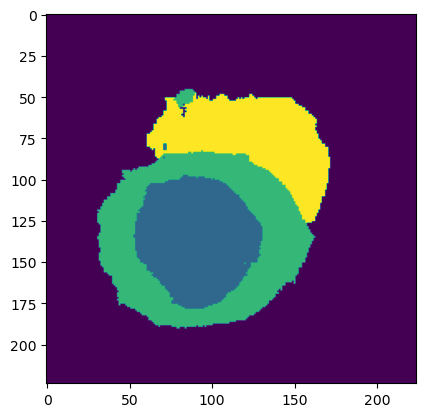

In [10]:
import matplotlib.pyplot as plt
prediction=prediction
print(prediction.shape)
plt.imshow(prediction[16,:,:]) ## look nice but not great

(32, 224, 224)


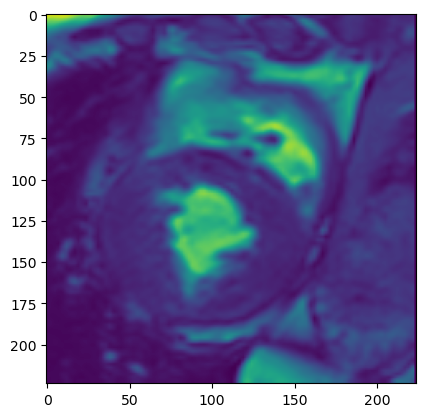

In [14]:
img=img_array
print(img.shape)  
plt.imshow(img[16,:,:])  ### image ground-truth

(32, 224, 224)


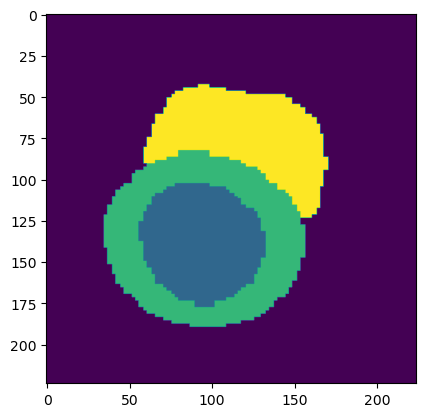

In [13]:
GT=mask_array
print(GT.shape)  
plt.imshow(GT[16,:,:])  ### ground-truth